# Photofatigue Measurements

## 1. Import Data and Preprocess for Photofatigue Measurements

In this first step, we import the necessary experimental data from a CSV file.

- **Timestamp filtering**: Only data after `2025-04-08` is used for analysis.



In [1]:
import pandas as pd

# Load experimental data
exp_data = pd.read_csv("DATA/Spectrumsfatigue.csv")

# Filter data to include only entries after a specific timestamp
exp_data = exp_data[exp_data["timestamp"] > "2025-04-08"]

# Display the filtered dataset
exp_data

,timestamp,cycle,type,186.85486,187.31995223015844,187.78500323297956,188.250012996982,188.71498151068454,189.17990876260572,189.64479474126426,...,1032.9632529736894,1033.3204920667242,1033.6776665334785,1034.034776362471,1034.3918215422202,1034.7488020612445,1035.1057179080635,1035.4625690711953,1035.8193555391586,1036.176077300472
863,2025-04-08 09:38:38.241780,0,zero,16.990556,24978.543889,347.456861,334.956667,350.490889,359.228889,371.365000,...,759.235111,750.739833,755.958361,750.497111,755.715639,744.793139,754.866111,767.123583,767.123583,767.123583
864,2025-04-08 09:39:44.486116,1,on,16.990556,24978.543889,352.796750,356.680306,352.796750,362.262917,357.772556,...,746.977639,739.453250,747.220361,749.162139,757.050611,759.720556,766.516778,749.768944,749.768944,749.768944
865,2025-04-08 09:40:19.529467,1,off,16.990556,24978.543889,358.986167,352.554028,341.631528,371.365000,379.010750,...,750.133028,751.468000,743.458167,763.968194,746.128111,754.866111,750.254389,757.414694,757.414694,757.414694
866,2025-04-08 09:40:25.564251,1,static,16.990556,24978.543889,357.408472,358.500722,346.850056,365.418306,381.802056,...,757.293333,741.273667,763.361389,770.643056,762.754583,767.244944,753.773861,760.327361,760.327361,760.327361
867,2025-04-08 09:40:40.608372,2,on,16.990556,24978.543889,365.054222,348.063667,360.199778,361.170667,372.093167,...,748.676694,744.914500,757.293333,764.089556,756.079722,753.167056,758.992389,746.249472,746.249472,746.249472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,2025-04-08 13:12:50.290246,228,off,16.990556,24978.543889,133.861306,130.705917,121.361111,138.230306,137.987583,...,527.192667,531.561667,525.979056,522.823667,544.425944,529.255806,546.489083,529.741250,529.741250,529.741250
1547,2025-04-08 13:12:56.349038,228,static,16.990556,24978.543889,114.928972,119.540694,125.001944,127.065083,139.686639,...,534.595694,513.721583,545.032750,522.459583,520.153722,537.629722,546.246361,533.867528,533.867528,533.867528
1548,2025-04-08 13:13:11.473565,229,on,16.990556,24978.543889,118.448444,124.880583,126.094194,121.482472,145.026528,...,532.047111,529.377167,523.915917,534.959778,522.338222,530.712139,535.930667,543.455056,543.455056,543.455056
1549,2025-04-08 13:13:46.542295,229,off,16.990556,24978.543889,122.332000,109.103639,114.564889,131.070000,147.332389,...,528.527639,536.658833,526.221778,529.983972,530.712139,527.678111,536.294750,537.022917,537.022917,537.022917


## 2. Data Preparation: Intensity Arrays & Absorbance Calculation

Now, we prepare the intensity data based on the "on", "off", "static", and "zero" conditions. These intensity values will be used to compute the absorbance values.

- **Intensity arrays**: Data for "on" and "off" states are extracted, along with the static and zero intensity references.
- **Absorbance formula**: Absorbance is calculated from the intensity data using the formula:

$$ A = -\log_{10}\left(\frac{I_{\text{on}} - I_{\text{static}}}{I_{\text{zero}} - I_{\text{static}}}\right) $$

where:
- $I_{\text{on}}$ is the intensity during the "on" state,
- $I_{\text{static}}$ is the static reference intensity,
- $I_{\text{zero}}$ is the zero intensity reference.

In [2]:
import numpy as np

# Extract relevant data for 'on', 'off', 'static', and 'zero' conditions
I_on = np.array(exp_data[exp_data["type"] == "on"].iloc[:, 3:], dtype=np.float64)
I_off = np.array(exp_data[exp_data["type"] == "off"].iloc[:, 3:], dtype=np.float64)
static = np.array(exp_data[(exp_data["type"] == "static")].iloc[:, 3:], dtype=np.float64)
zero = np.array(exp_data[(exp_data["type"] == "zero")].iloc[:, 3:], dtype=np.float64)

# Extract wavelengths (assumed to be in columns from 3 onward)
wavelengths = np.array(exp_data.columns[3:], dtype=np.float64)

# Convert timestamps to seconds since the first "on" timestamp
t_on = pd.to_datetime(exp_data["timestamp"][exp_data["type"] == "on"])
t_on = np.array((t_on - t_on.iloc[0]).dt.total_seconds())

t_off = pd.to_datetime(exp_data["timestamp"][exp_data["type"] == "off"])
t_off = np.array((t_off - t_off.iloc[0]).dt.total_seconds())

# Function to calculate absorbance
def compute_absorbance(intensities: np.ndarray, static: np.ndarray, zero: np.ndarray) -> np.ndarray:
    EPS = 1e-12  # Small epsilon to avoid division by zero
    num = intensities - static
    den = np.maximum(zero - static, EPS)  # Prevent division by zero
    absorbance = -np.log10(np.maximum(num / den, EPS))  # Avoid log(0) or negative
    return absorbance

# Calculate absorbance for "on" and "off" intensities
A_on = compute_absorbance(I_on, static, zero)
A_off = compute_absorbance(I_off, static, zero)


## 3. Plot Absorbance vs Time for Selected Wavelengths

In this section, we visualize the absorbance data over time for selected wavelengths (408 nm and 480 nm). This helps to assess the photofatigue effects at these specific wavelengths.

- **Plotting**: We plot the absorbance for both "on" and "off" conditions for each of the selected wavelengths.

The absorbance is shown as a function of time for the given wavelength range.


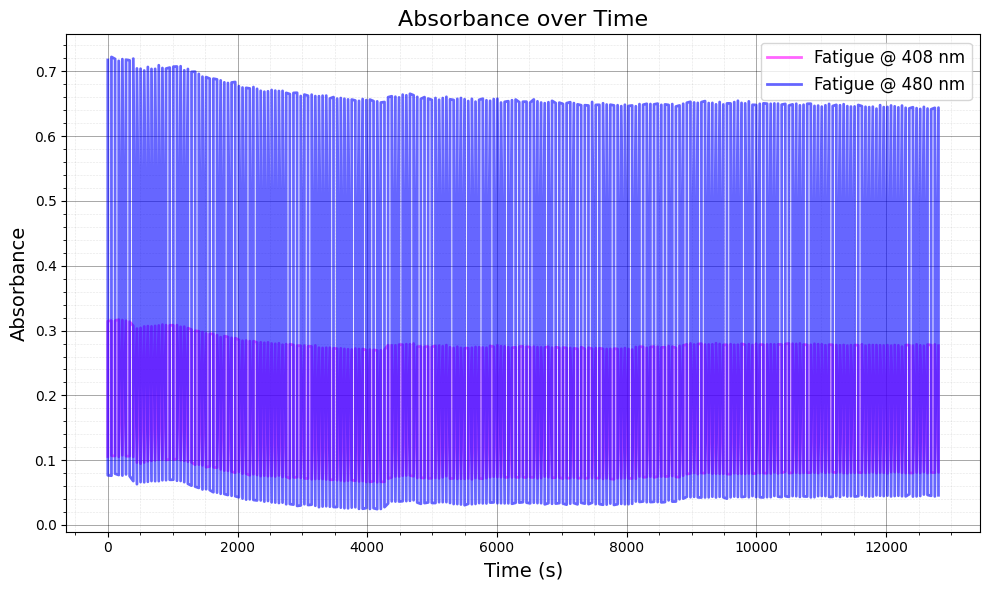

In [3]:
import matplotlib.pyplot as plt

# Define target wavelengths (in nm)
wavelength_target = [408, 480]
wavelength_idxs = np.argmin(np.abs(wavelengths[:, None] - np.array(wavelength_target)), axis=0)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
colors = [["#FF00FF", "#412544"], ["blue", "red"]]  # Colors for different wavelengths

# Plot absorbance over time for selected wavelengths
for i, idx in enumerate(wavelength_idxs):
    t_combined = np.concatenate([t_on, t_off])  # Combine on and off times
    A_combined = np.concatenate([A_on[:, idx], A_off[:, idx]])  # Combine on and off absorbance

    # Sort by time
    sorted_indices = np.argsort(t_combined)
    t_sorted = t_combined[sorted_indices]
    A_sorted = A_combined[sorted_indices]

    # Plot combined data
    ax.plot(
        t_sorted, A_sorted,
        label=f"Fatigue @ {wavelengths[idx]:.0f} nm",
        color=colors[i][0],  # Color for each wavelength
        linewidth=2,
        alpha=0.6,
    )

# Set axis labels and title
ax.set_title("Absorbance over Time", fontsize=16)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Absorbance", fontsize=14)

# Add legend and grid
ax.legend(fontsize=12)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.6, color='black', alpha=0.4)
ax.grid(which='minor', linestyle=':', linewidth=0.4, color='black', alpha=0.2)

# Ensure layout is tidy
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


## 4. Adjust Absorbance for Offset and Plot

Here, we adjust the absorbance data for the "on" and "off" conditions by subtracting the absorbance at a reference wavelength (550 nm) to account for baseline shifts. This correction ensures a more accurate comparison between wavelengths.

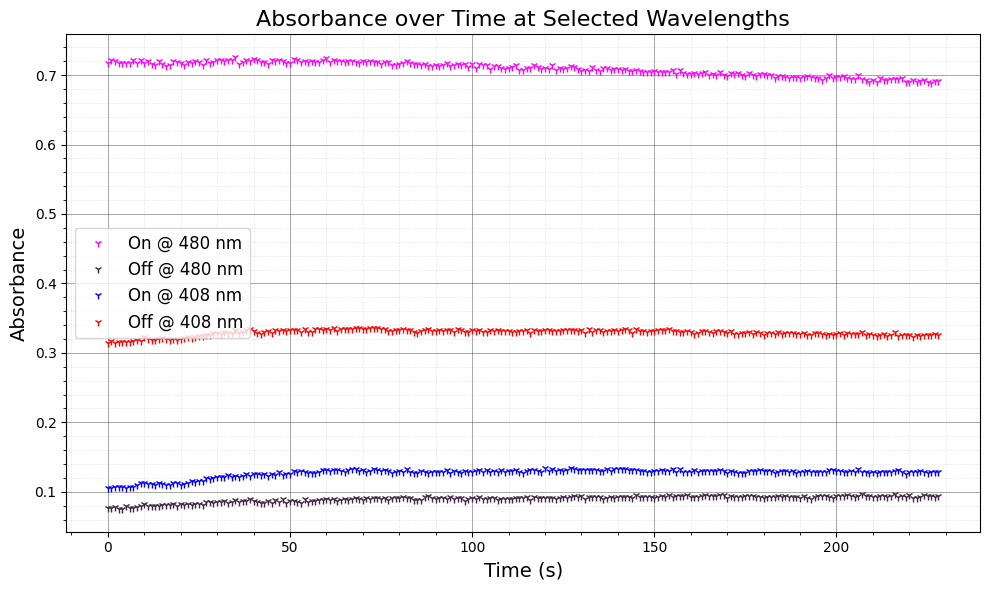

In [4]:
# Define target wavelengths
wavelength_target = [480, 408]
wavelength_idxs = np.argmin(np.abs(wavelengths[:, None] - np.array(wavelength_target)), axis=0)

# Reference wavelength for adjustment (e.g., 550 nm)
wlt = 550
id2 = np.argmin(np.abs(wavelengths[:, None] - np.array(wlt)))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
colors = [["#FF00FF", "#412544"], ["blue", "red"]]  # Colors for different wavelengths

# Plot absorbance over time with adjustments
for i, idx in enumerate(wavelength_idxs):
    # Adjust "on" absorbance data
    ax.plot(
        A_on[:, idx] - 1 * (A_on[:, id2] - np.min(A_on[0, id2])), "1",
        label=f"On @ {wavelengths[idx]:.0f} nm",
        color=colors[i][0],
        linewidth=2
    )

    # Adjust "off" absorbance data
    ax.plot(
        A_off[:, idx] - 1 * (A_off[:, id2] - np.min(A_off[0, id2])), "1",
        label=f"Off @ {wavelengths[idx]:.0f} nm",
        color=colors[i][1],
        linewidth=2
    )

# Set axis labels and title
ax.set_title("Absorbance over Time at Selected Wavelengths", fontsize=16)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Absorbance", fontsize=14)

# Add legend and grid
ax.legend(fontsize=12)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.6, color='black', alpha=0.4)
ax.grid(which='minor', linestyle=':', linewidth=0.4, color='black', alpha=0.2)

# Ensure layout is tidy
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


## 5. Linear Fit and Time Constant Estimation

We now perform a linear regression on the absorbance data to estimate the time constant (τ) for the photofatigue process. This is calculated by fitting the absorbance data to a linear model, where the slope gives us the decay rate.

- **Linear regression**: We fit the absorbance data after the initial part of the signal (after 50 seconds) to a linear model.
- **Time constant**: From the linear regression results, we calculate the time constant as $( \tau_{1/2} = \frac{-\text{intercept}}{2 \times \text{slope}} )$, and express it in hours.

The time constant helps to quantify the rate of photofatigue.


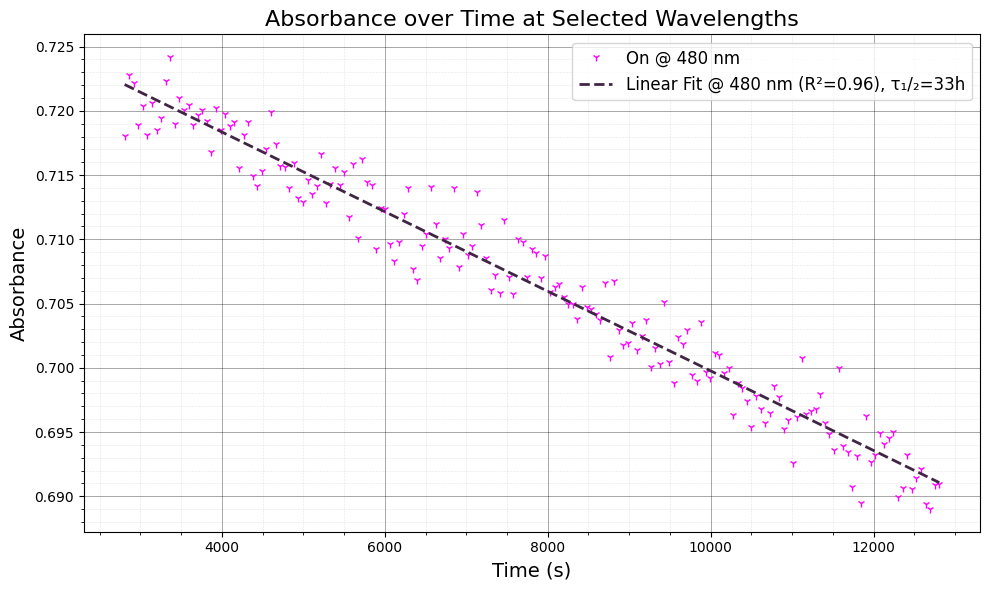

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define target wavelength (480 nm)
wavelength_target = [480]
wavelength_idxs = np.argmin(np.abs(wavelengths[:, None] - np.array(wavelength_target)), axis=0)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
colors = [["#FF00FF", "#412544"], ["blue", "red"]]  # Colors for different wavelengths

# Compute adjusted absorbance data
dat = A_on[:, idx] - 1 * (A_on[:, id2] - np.min(A_on[0, id2]))

# Plot absorbance data with linear regression
for i, idx in enumerate(wavelength_idxs):
    t = t_on[50:]  # Start from second 50 onward
    y = dat[50:]

    # Plot raw absorbance data
    ax.plot(t, y, "1", label=f"On @ {wavelengths[idx]:.0f} nm", color=colors[i][0], linewidth=2)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(t, y)
    y_fit = slope * t + intercept

    # Plot regression line and annotate with R^2 and time constant
    ax.plot(t, y_fit, "--", label=f"Linear Fit @ {wavelengths[idx]:.0f} nm (R²={r_value**2:.2f}), τ₁/₂={-intercept/2*1/slope/60/60:.0f}h", color=colors[i][1], linewidth=2)

# Set axis labels and title
ax.set_title("Absorbance over Time at Selected Wavelengths", fontsize=16)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("Absorbance", fontsize=14)

# Add legend and grid
ax.legend(fontsize=12)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.6, color='black', alpha=0.4)
ax.grid(which='minor', linestyle=':', linewidth=0.4, color='black', alpha=0.2)

# Final layout
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()
